# Investigating Factors of Rising House Values in New York City: Step 2 (Analysis)

Team Members: Francisco Brady (fbrady), Zhonghan Xie (jonasxie), Michael Garner (mngarner)  
Date: 2024-11-06

## Background and Guiding Questions

As house prices continue to rise in New York City, the ripple effects on communities are profound. For example, the median home price in NYC reached approximately \$754,000 as of September 2024, 29.5\% increase from that of September 2017. While rapidly increasing property values may signal economic growth, they also contribute to housing instability and displacement, particularly among lower-income residents. At the same time, access to quality educational resources remains a crucial factor for many families in deciding where to live. In areas where public schools are highly rated and well-attended, home prices often exceed city averages, reflecting the economic value of educational resources placed on educational quality. This project aims to investigate the factors that contribute to rising house prices in NYC, their impact on eviction rates and the intersection between educational outcomes and housing markets. By understanding these relationships, we hope to inform policymakers and community stakeholders on how to address the challenges of access to quality education, housing affordability and stability in the city.

Three questions that we seek to answer in an analysis of housing price, eviction rate, and educational datasets for NYC are:
1. What impact does rising housing prices have on eviction rates in NYC? Are these strongly correlated?
2. Does the change in eviction rate due to housing prices predict a change in primary/secondary education attendance? Specifically: do neighborhoods with higher eviction rates, potentially due to rising housing costs, see a decrease in school attendance?
3. How do the relationships between housing prices, eviction rates, and education vary across different neighborhoods in NYC? Do the predictive relationships differ in locations with different socioeconomic characteristics?

## Descriptive Statistics

Guidance:

Provide a comprehensive summary of your combined dataset using descriptive statistics. This should include means, medians, modes, ranges, variance, and standard deviations for the relevant features of your data.  The descriptive statistics should inform your guiding questions that you developed in Part I of the project, rather than merely providing an overview of your data.  Interpret these results to draw preliminary conclusions about the data.

In [109]:
# Import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

In [74]:
# Will change with merged data, but import data
allData = pd.read_csv('./data/analytic_dataset.csv')

## replace NaN with np.NA across entire dataframe
allData = allData.replace({np.nan: None})
## rename EVICTION_COUNT to eviction
## drop second YEAR variable
allData.rename(columns = {'EVICTION_COUNT':'eviction'}, inplace = True)
allData.rename(columns={'GEOID':'tract'}, inplace = True)
allData.drop(columns = ['YEAR'], inplace = True)
## convert all nonstring columns to numeric
allData = allData.apply(pd.to_numeric, errors='ignore')

/tmp/ipykernel_1265356/3069907705.py:12: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  allData = allData.apply(pd.to_numeric, errors='ignore')


In [75]:
allData.head()

,DBN,school_name,school_type,academic_type,grade_type,open_date,status,address,community_district,council_district,...,total_population,median_income,white_pct,black_pct,american_indian_alaska_native_pct,asian_pct,hawaiian_pacific_islander_pct,multiple_race_pct,other_race_pct,eviction
0,15K001,P.S. 001 The Bergen,DOE,General Academic,Elementary,1965-07-01T00:00:00.000,Open,309 47 STREET,307.0,38.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15K001,P.S. 001 The Bergen,DOE,General Academic,Elementary,1965-07-01T00:00:00.000,Open,309 47 STREET,307.0,38.0,...,1503.0,18941.0,40.652,2.728,10.313,6.055,0.0,1.464,39.521,NaN
2,15K001,P.S. 001 The Bergen,DOE,General Academic,Elementary,1965-07-01T00:00:00.000,Open,309 47 STREET,307.0,38.0,...,1738.0,25856.0,42.750,3.625,0.000,23.072,0.0,4.603,28.251,NaN
3,15K001,P.S. 001 The Bergen,DOE,General Academic,Elementary,1965-07-01T00:00:00.000,Open,309 47 STREET,307.0,38.0,...,5328.0,23235.0,33.296,0.638,1.126,30.593,0.0,9.685,29.505,9.0
4,15K001,P.S. 001 The Bergen,DOE,General Academic,Elementary,1965-07-01T00:00:00.000,Open,309 47 STREET,307.0,38.0,...,5431.0,24473.0,41.300,3.701,0.110,19.923,0.0,29.571,20.180,14.0


In [105]:
# Descriptive statistics for the key variables: evictions, school absenteeism, housing prices
# Mean, median, mode, std dev, range, IQR, etc
# Box plot for each
allData.columns
keepCols = ['year', 'DBN', 'pct_attendance', 'tract',
       'pct_chronically_absent', 'nta_code', 'nta_name', 'borough',
       'number_of_sales', 'average_sale_price', 'median_sale_price',
       'lowest_sale_price', 'highest_sale_price', 'hvi', 'total_population',
       'eviction',
       'median_income', 'white_pct', 'black_pct',
       'american_indian_alaska_native_pct', 'asian_pct',
       'hawaiian_pacific_islander_pct', 'multiple_race_pct', 'other_race_pct']
# keep only the columns we want
allData = allData[keepCols]
# create log house value index
allData['log_hvi'] = np.log(allData['hvi'])
# create minority majority indicator variable
allData['minority_majority'] = np.where(allData['white_pct'] < 50, 1, 0)
# create low, medium, high income indicator variables derived from median_income
low_income = allData['median_income'].quantile(0.33)
high_income = allData['median_income'].quantile(0.67)
allData['income_level'] = np.where(allData['median_income'] < low_income, 'low',
                                   np.where(allData['median_income'] < high_income, 'medium', 'high'))

### Description of key variables

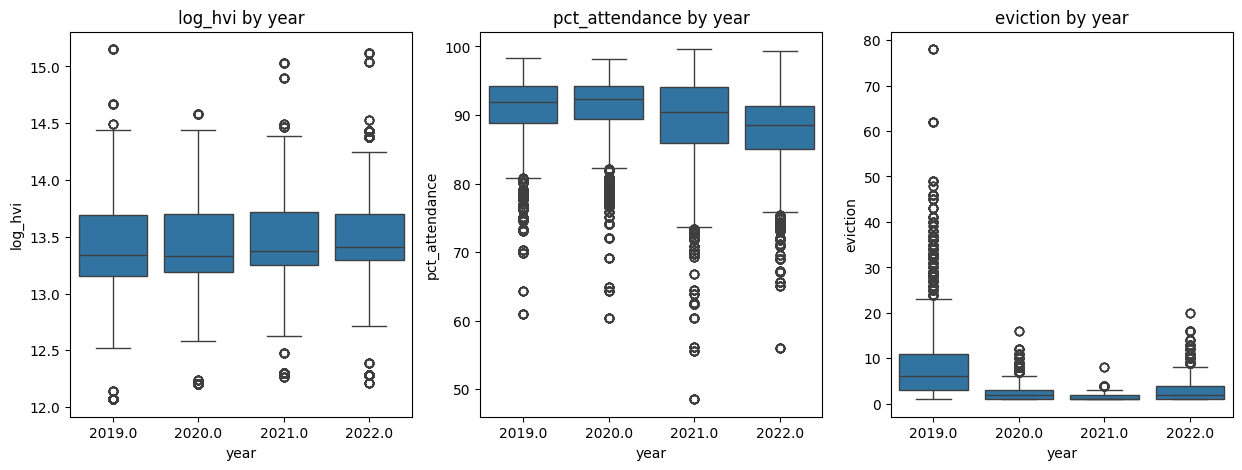

In [97]:
varlist = ['log_hvi', 'pct_attendance', 'eviction']
## create one row of 3 boxplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, var in enumerate(varlist):
    sns.boxplot(x='year', y=var, data=allData, ax=axs[i])
    axs[i].set_title(f'{var} by year')

In [98]:
## generate descriptive statistics per year for key variables
varlist = ['log_hvi', 'pct_attendance', 'eviction']
def desc_stats(data, varlist):
    desc = data.groupby('year')[varlist].agg(['mean', 'median', 'std', 'min', 'max'])
    desc = desc.round(2)
    return desc
# print descriptive statistics
desc_stats(allData, varlist)

log_hvi                            pct_attendance                      \
          mean median   std    min    max           mean median   std    min   
year                                                                           
2019.0   13.41  13.34  0.43  12.07  15.15          90.88  91.92  4.74  61.01   
2020.0   13.41  13.33  0.40  12.20  14.58          91.17  92.40  4.62  60.45   
2021.0   13.45  13.37  0.40  12.26  15.03          89.26  90.47  6.65  48.54   
2022.0   13.48  13.41  0.41  12.22  15.12          87.62  88.55  5.18  56.05   

              eviction                          
          max     mean median   std  min   max  
year                                            
2019.0  98.32     8.65    6.0  8.71  1.0  78.0  
2020.0  98.11     2.54    2.0  2.02  1.0  16.0  
2021.0  99.59     1.58    1.0  0.94  1.0   8.0  
2022.0  99.32     2.93    2.0  2.32  1.0  20.0

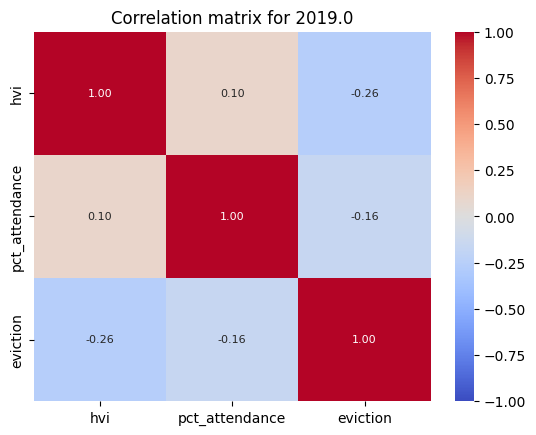

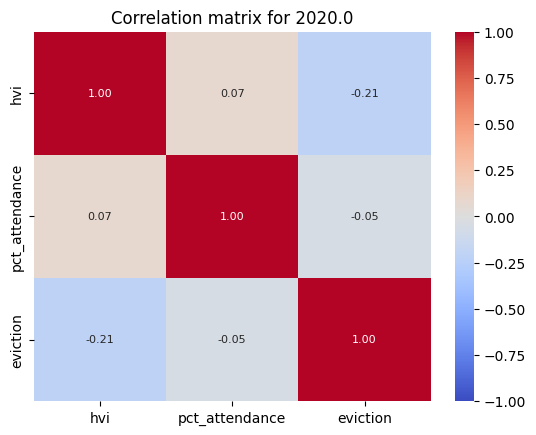

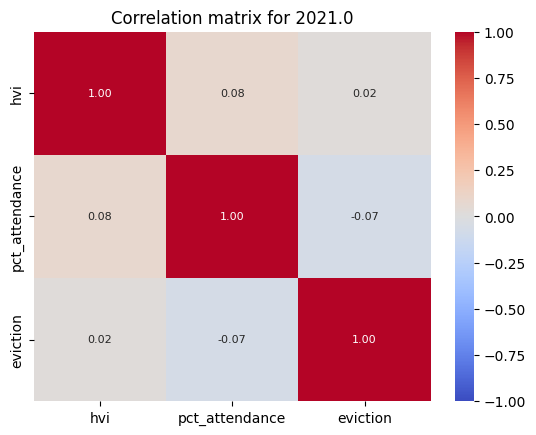

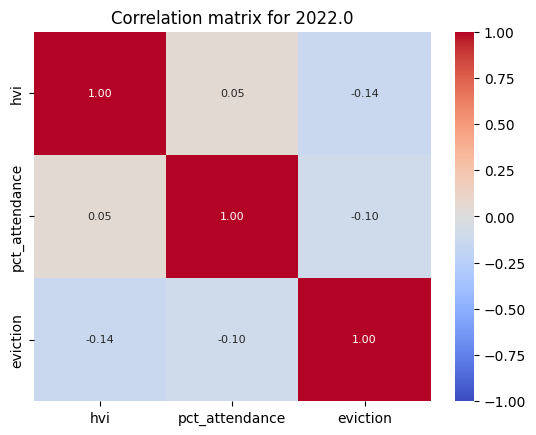

In [46]:
## corrplot of key variables by year
for year in allData['year'].unique():
    data = allData[allData['year'] == year]
    avg_data = data[varlist].mean()
    corr = data[varlist].corr()
    sns.heatmap(corr, cmap="coolwarm",vmax=1,vmin=-1,annot=True, fmt=".2f", annot_kws={"size": 8})
    plt.title(f'Correlation matrix for {year}')
    plt.show()

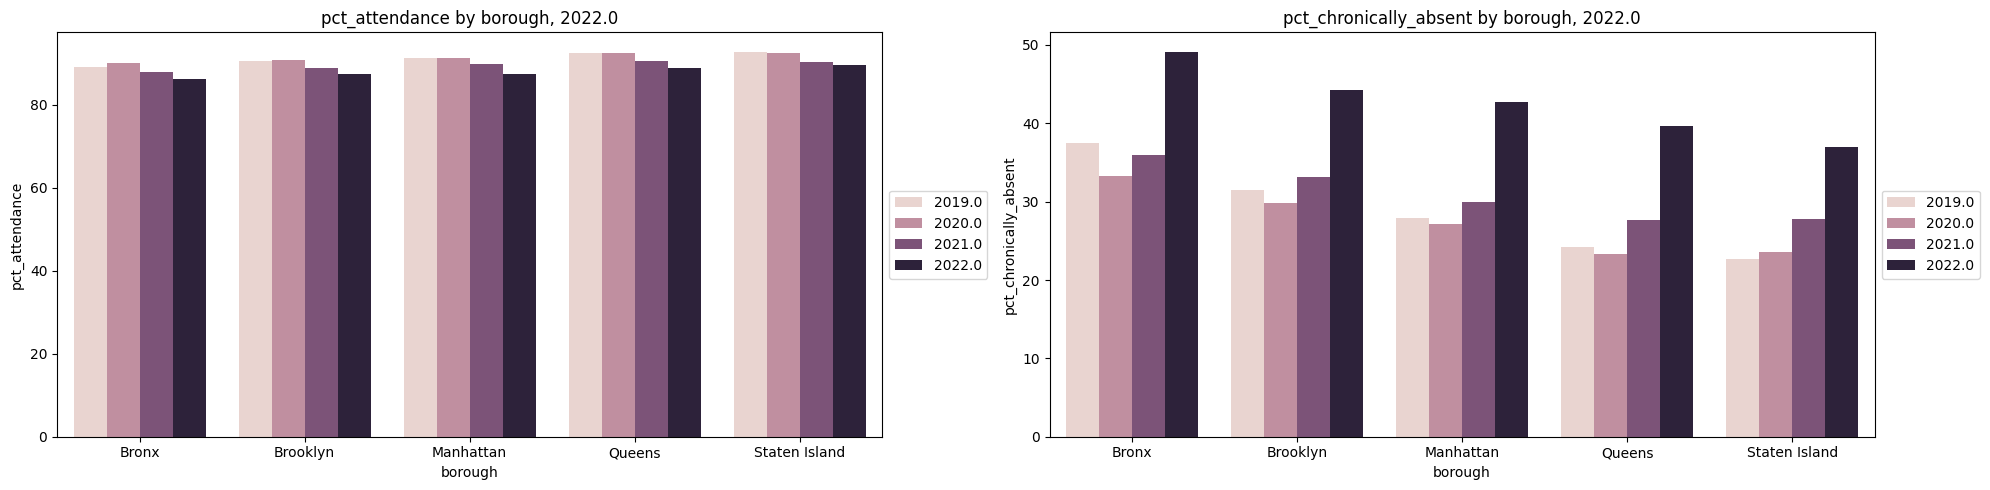

In [65]:
## bar plot average yearly values by borough for school variables
# arrange in 2x2 grid 
school_vars = ['pct_attendance', 'pct_chronically_absent']
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
for i, var in enumerate(school_vars):
    avg_data = allData.groupby(['year', 'borough'])[var].mean().reset_index()
    sns.barplot(x='borough', y=var, data=avg_data, ax=axs[i], hue='year')
    axs[i].set_title(f'{var} by borough, {year}')
    # legend to outside bottom of plot
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

Interpretation: 

## Inferential Statistics

Guidance:

Conduct appropriate hypothesis tests to investigate if there are significant differences or correlations within your data.  This might involve regression analysis, ANOVA, and/or chi-squared tests.

Clearly state your null and alternative hypotheses, choose an appropriate significance level, and discuss your findings. Make sure to justify the choice of your tests.

Research questions and associated hypotheses to be answered in the inferential analysis:

1. How are housing prices related to eviction rates? Do areas with higher housing prices have higher eviction rates?
    - Null hypothesis (H0): There is no relationship between housing prices and eviction rates.
    - Alternative hypothesis (Ha): There is a relationship between housing prices and eviction rates.
2. Is the impact of income on eviction rates mediated by housing prices?
    - H0: There is no relationship between housing prices and the impact of income on eviction rates.
    - Ha: Housing prices mediate the relationship between income and eviction rates.
3. Do neighborhoods with higher eviction rates see a decrease in school attendance?
    - H0: There is no relationship between eviction rates and school attendance.
    - Ha: There is a negative association between eviction rates and school attendance.
4. Is the impact of income on school attendance mediated by evictions?
    - H0: There is no relationship between evictions and the impact of income on school attendance.
    - Ha: Evictions mediate the relationship between income and school attendance.
5. How do the relationships between housing prices, evictions, and chronic absenteeism vary between minority and white-dominant neighborhoods?
    - H0: There is no statistically significant difference in the relationships between housing prices, evictions, and chronic absenteeism between minority and white-dominant neighborhoods.
    - Ha: The relationships between housing prices, evictions, and chronic absenteeism differ between minority and white-dominant neighborhoods.
6. How do the relationships between housing prices, evictions, and chronic absenteeism vary between low, medium and high income neighborhoods?
    - H0: There is no statistically significant difference in the relationships between housing prices, evictions, and chronic absenteeism between neighborhoods of different income levels.
    - Ha: The relationships between housing prices, evictions, and chronic absenteeism differ by neighborhood income level.


In [121]:
# t-tests?


In [119]:
allData['income_level'].value_counts()

income_level
high      22598
medium    21724
low       21132
Name: count, dtype: int64

ANOVAs:
- Housing prices, eviction rates, chronic absenteeism by minority vs non-minority dominated neighborhoods
- Housing prices, evictions, and school attendance by income level (low, medium, high income neighborhoods)

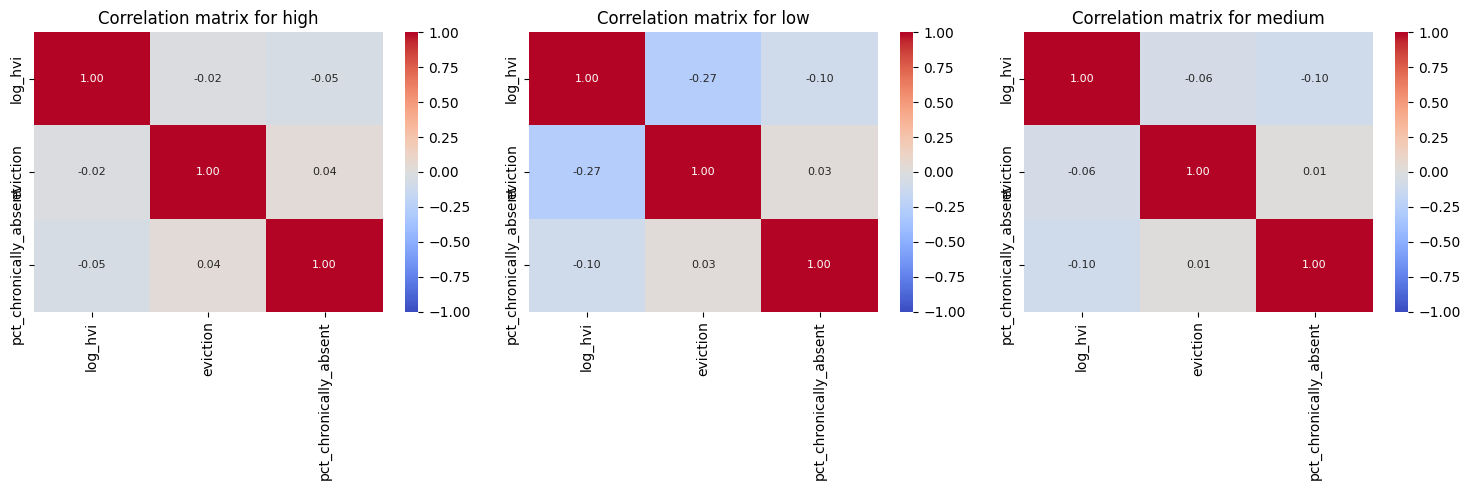

In [120]:
# List of variables to consider for the correlation matrix
vars = ['log_hvi', 'eviction', 'pct_chronically_absent']

# Create subplots with 3 columns and 1 row
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loop over unique income levels and create a heatmap for each
for i, income in enumerate(allData['income_level'].unique()):
    data = allData[allData['income_level'] == income]
    corr = data[vars].corr()
    sns.heatmap(corr, cmap="coolwarm", vmax=1, vmin=-1, annot=True, fmt=".2f", annot_kws={"size": 8}, ax=axs[i])
    axs[i].set_title(f'Correlation matrix for {income}')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Mediation analysis: income -> housing -> evictions

# 1. Regression analysis of income and evictions

# 2. Regression analysis of income and housing prices

# 3. Regression analysis of housing prices and evictions

# 4. Multiple regression of income and housing prices on evictions

# fit models

m1 = smf.ols('eviction ~ log_hvi + I(borough) + I(year)', data=allData).fit()
m3 = smf.ols('pct_attendance ~ eviction + I(nta_name) + I(year)', data=allData).fit()
m4 = smf.ols('pct_attendance ~ eviction + median_income + I(borough) + I(year)', data=allData).fit()
m5 = smf.ols('log_hvi ~ eviction + pct_chronically_absent + I(income_level) + I(borough) + I(year)', data=allData).fit()

## regression output
results = summary_col([m1, m3, m4, m5], info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
    'R2':lambda x: "{:.2f}".format(x.rsquared)},
    stars=True,
    model_names=['m1', 'm3', 'm4', 'm5'])
print(results)


In [ ]:
# Mediation analysis: income -> evictions -> absenteeism

# 1. Regression analysis of income and absenteeism

# 2. Regression analysis of income and evictions (already done)

# 3. Regression analysis of evictions and absenteeism

# 4. Multiple regression of income and evictions on absenteeism

In [122]:
# ANOVA tests for housing prices, eviction rates, school attendance for low, medium, high income neighborhoods
# Define low = < Q1, medium = Q1 to Q3, high = > Q3
anova_1 = smf.ols('log_hvi ~ C(income_level)', data=allData).fit()
anova_2 = smf.ols('eviction ~ C(income_level)', data=allData).fit()
anova_3 = smf.ols('pct_attendance ~ C(income_level)', data=allData).fit()

# print results tables
print(anova_1.summary())
print(anova_2.summary())
print(anova_3.summary())


                            OLS Regression Results                            
Dep. Variable:                log_hvi   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     5464.
Date:                Wed, 06 Nov 2024   Prob (F-statistic):               0.00
Time:                        19:11:22   Log-Likelihood:                -29139.
No. Observations:               65454   AIC:                         5.828e+04
Df Residuals:                   65451   BIC:                         5.831e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [ ]:
# ANOVA tests for housing prices, eviction rates, school attendance for white/minority dominated neighborhoods
# majority minority = < 50% white, 
anova_4 = smf.ols('log_hvi ~ C(minority_majority)', data=allData).fit()
anova_5 = smf.ols('eviction ~ C(minority_majority)', data=allData).fit()
anova_6 = smf.ols('pct_attendance ~ C(minority_majority)', data=allData).fit()

# print results tables
print(anova_4.summary())
print(anova_5.summary())
print(anova_6.summary())


## Graphical Analysis

Guidance:

Create various types of plots to visualize relationships within your data. Use histograms, bar charts, scatter plots, box plots, and any other suitable graphical representations you've learned.

Be sure to use appropriate titles, labels, and legends to make your plots readable and informative.

Interpret the graphical representations to uncover patterns, trends, and outliers.


In [ ]:
# May be redundant with the above, maybe add some pairplots

## Comparative Analysis

Guidance:

Compare and contrast different subsets of your data. This can include comparisons over time, across different categories, or any other relevant segmentation.  Note that for some projects, the nature of this comparative analysis will be obvious.  For others, you will need to think about how you might subset your data.

Discuss any notable similarities or differences you have identified.


Subsets to examine/comparisons to make:
1. Housing prices, evictions, and school attendance by race (minority-dominant vs white-dominant neighborhoods)
- Multi-line plots: housing prices, evictions, and school attendance, each a seprate figure, plotted by racial perecentage (white, black, asian, islander, etc)
2. Housing prices, evictions, and school attendance by income level (low, medium, high income neighborhoods)
- Multi-line plots as well

Most of this is done in the inferential statistics section. Can reproduce or reference the ANOVAs and add plots to substantiate, then discuss.

In [ ]:
# Maybe do additional comparisons based on demographic characteristics

## Multivariate Analysis

Guidance:

Perform multivariate analysis to understand the relationships among three or more variables in your dataset.

Use techniques like cross-tabulation, pivot tables, and multivariate graphs.


In [ ]:
# Pairplot and correlation heatmap for all variables

## Synthesis

Guidance:

Synthesize the findings from your descriptive and inferential statistics along with your graphical analyses to answer your research questions.

Discuss how the combination of the datasets has provided added value in terms of insights or capabilities that would not be possible with the individual datasets in isolation.


More expanded version of the interpretation blocks for descriptive, inferential statistics

## Reflection

Include a section (using one or more markdown blocks) at the end of your notebook in which you reflect on the process of analyzing the data. Discuss any challenges you encountered and how you overcame them.

Critically evaluate the limitations of your analysis and suggest areas for further research or improvement.


Obvious: reducing complex socioeconomic phenomena such as school truancy and evictions to a few variables likely oversimplifies the problem. The relationships between housing prices, eviction rates, and school attendance are likely to be mediated by a variety of other factors, such as income, employment, and social services.